In [ ]:
# !pip install sqlalchemy pymysql pandas matplotlib ipython PrettyTable fpdf yagmail

Initial Price => 5000
Price After Room Type Adjustment => 5500 (+10.00%)
Price After Weekend Surge Charge => 5775 (+5.00%)
Price After Summer Season Adjustment => 6641 (+15.00%)
Price After Room Availability Charge => 7836 (+18.00%)
Price After Loyalty Discount => 7836 (No Change)
Price After Special Offer Period => 7836 (No Change)
PDF saved as Booking_Info_8.pdf

Booking Information:
+---------------+---------------------+
|     Field     |         Data        |
+---------------+---------------------+
|      Name     |         Jake        |
|    Address    |          NY         |
|     Email     |     jake@xyz.in     |
|     Phone     |      683748331      |
| Check-in Date | 2025-03-15 00:00:00 |
|  Room Number  |          9          |
|   Room Type   |          N          |
|   Room Price  |         7836        |
|  Booking Time | 2024-08-10 10:00:46 |
+---------------+---------------------+
Final price updated successfully for room 9 to 7836✔️


,id,room_no,price,room_type,currently_booked,created_at
0,9,9,7836,N,0,2024-07-15 06:11:15


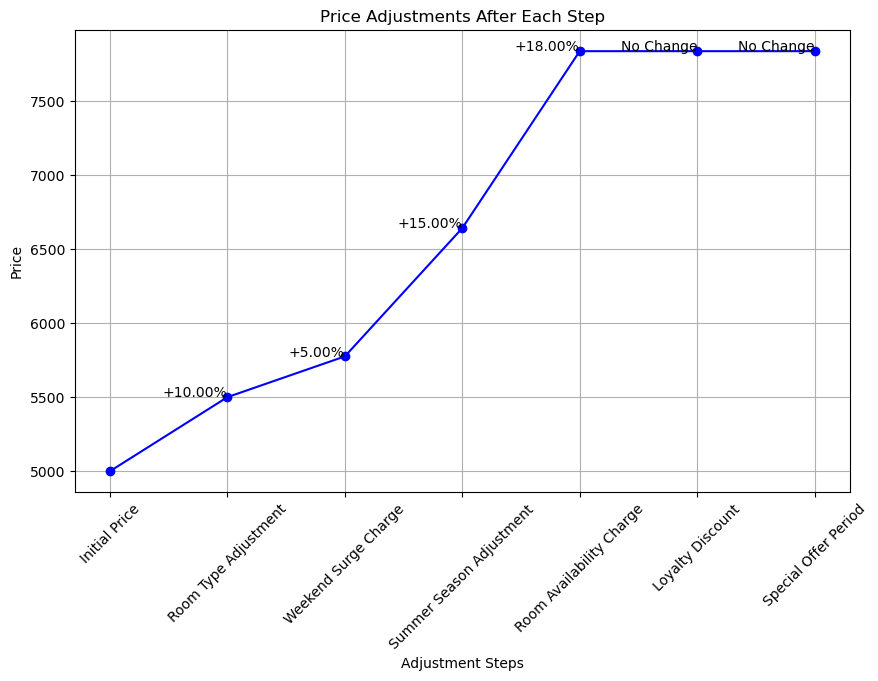

In [8]:
from sqlalchemy import create_engine, Column, Integer, String, Boolean, DateTime, ForeignKey
from sqlalchemy.orm import declarative_base, sessionmaker, relationship
import datetime
from prettytable import PrettyTable
import matplotlib.pyplot as plt
import time
from IPython.display import display, clear_output
from fpdf import FPDF
import pandas as pd

# Database connection parameters
username = 'root'
password = 'iamukr77'
host = 'localhost'
port = '3306'  # Default MySQL port
database = 'hms'  # Your schema name

# Create an engine instance with provided credentials
engine = create_engine(f'mysql+pymysql://{username}:{password}@{host}:{port}/{database}')

# Define the ORM base class
Base = declarative_base()

# Define the ORM mapping for the rooms table
class Room(Base):
    __tablename__ = 'rooms'
    id = Column(Integer, primary_key=True, autoincrement=True)
    room_no = Column(Integer, unique=True)
    price = Column(Integer)
    room_type = Column(String(2))
    currently_booked = Column(Boolean, default=False)
    created_at = Column(DateTime, default=datetime.datetime.utcnow)

    reservations = relationship("Reservation", back_populates="room")

# Define the ORM mapping for the reservations table
class Reservation(Base):
    __tablename__ = 'reservations'
    id = Column(Integer, primary_key=True, autoincrement=True)
    g_id = Column(Integer, ForeignKey('guests.id'))
    r_date = Column(DateTime)
    check_in = Column(DateTime)
    check_out = Column(DateTime)
    meal = Column(Boolean)
    r_id = Column(Integer, ForeignKey('rooms.id'))
    r_type = Column(String(2))
    created_at = Column(DateTime, default=datetime.datetime.utcnow)

    guest = relationship("Guest", back_populates="reservations")
    room = relationship("Room", back_populates="reservations")

# Define the ORM mapping for the guests table
class Guest(Base):
    __tablename__ = 'guests'
    id = Column(Integer, primary_key=True, autoincrement=True)
    name = Column(String(30))
    address = Column(String(50))
    email_id = Column(String(50))
    phone = Column(Integer)
    city = Column(String(20))
    created_at = Column(DateTime, default=datetime.datetime.utcnow)

    reservations = relationship("Reservation", back_populates="guest")

# Create a sessionmaker
Session = sessionmaker(bind=engine)

# Function to calculate dynamic price based on room type, weekends, and summer season
def calculate_dynamic_price(room, reservation):
    prices = []
    labels = []
    changes = []
    
    base_price = 5000  # Example base price
    prices.append(base_price)
    labels.append('Initial Price')
    changes.append('')
    print(f"Initial Price => {base_price}")
    
    # Adjust price based on room type
    previous_price = base_price
    if room.room_type == 'D':  # Deluxe room
        base_price += 1000
    elif room.room_type == 'N':  # Normal room
        base_price += 500
    
    percentage_change = ((base_price - previous_price) / previous_price) * 100
    prices.append(base_price)
    labels.append('Room Type Adjustment')
    changes.append(f"+{percentage_change:.2f}%" if percentage_change != 0 else "No Change")
    print(f"Price After Room Type Adjustment => {base_price} ({changes[-1]})")
    
    # Check if the check_in date was a weekend
    previous_price = base_price
    created_at_date = reservation.check_in
    is_weekend_flag = created_at_date.weekday() >= 5  # 5 represents Saturday, 6 represents Sunday

    if is_weekend_flag:
        base_price *= 1.05  # Increase price by 5% for rooms created on weekends
    
    percentage_change = ((base_price - previous_price) / previous_price) * 100
    prices.append(int(base_price))
    labels.append('Weekend Surge Charge')
    changes.append(f"+{percentage_change:.2f}%" if percentage_change != 0 else "No Change")
    print(f"Price After Weekend Surge Charge => {int(base_price)} ({changes[-1]})")
    
    # Check if the created_at date falls within the summer season (March and April)
    previous_price = base_price
    if created_at_date.month in [3, 4]:
        base_price *= 1.15  # Increase price by 15% for rooms booked during the summer season
    
    percentage_change = ((base_price - previous_price) / previous_price) * 100
    prices.append(int(base_price))
    labels.append('Summer Season Adjustment')
    changes.append(f"+{percentage_change:.2f}%" if percentage_change != 0 else "No Change")
    print(f"Price After Summer Season Adjustment => {int(base_price)} ({changes[-1]})")
    
    return int(base_price), prices, labels, changes

# Function to check if the room is booked
def is_room_booked(room_no, session):
    reservation = session.query(Reservation).join(Room).filter(Room.room_no == room_no, Reservation.check_out == None).first()
    return reservation is not None

# Function to apply dynamic price based on room availability
def update_room_price(room_no, session, current_price):
    previous_price = current_price
    if is_room_booked(room_no, session):
        current_price *= 1.18  # Increase price by 18%
    
    percentage_change = ((current_price - previous_price) / previous_price) * 100
    print(f"Price After Room Availability Charge => {int(current_price)} ({f'+{percentage_change:.2f}%' if percentage_change != 0 else 'No Change'})")
    return int(current_price), f"+{percentage_change:.2f}%" if percentage_change != 0 else "No Change"

# Function to apply loyalty discount
def apply_loyalty_discount(current_price, guest):
    previous_price = current_price
    if guest.email_id in ['ukr@abc.in', 'ukr@abc.com']:
        current_price = int(current_price * 0.8)  # Apply 20% discount
    
    percentage_change = ((current_price - previous_price) / previous_price) * 100
    print(f"Price After Loyalty Discount => {current_price} ({f'{percentage_change:.2f}%' if percentage_change != 0 else 'No Change'})")
    return current_price, f"{percentage_change:.2f}%" if percentage_change != 0 else "No Change"

# Function to apply special offer period specific date
def apply_special_offer(current_price, reservation):
    previous_price = current_price
    offer_start_date = datetime.datetime(2024, 4, 20)
    offer_end_date = datetime.datetime(2024, 4, 30)
    
    if offer_start_date <= reservation.check_in <= offer_end_date:
        current_price = int(current_price * 0.93)  # Apply 7% discount
    
    percentage_change = ((current_price - previous_price) / previous_price) * 100
    print(f"Price After Special Offer Period => {current_price} ({f'{percentage_change:.2f}%' if percentage_change != 0 else 'No Change'})")
    return current_price, f"{percentage_change:.2f}%" if percentage_change != 0 else "No Change"

# Function to fetch and display guest information along with reservation and room details
def get_guest_info(guest_id, session, final_price):
    guest = session.query(Guest).filter_by(id=guest_id).first()
    reservation = session.query(Reservation).filter_by(g_id=guest_id, check_out=None).first()
    room = session.query(Room).filter_by(id=reservation.r_id).first() if reservation else None
    
    current_time = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    
    if guest and reservation and room:
        # Create a PrettyTable instance
        table = PrettyTable()
        table.field_names = ["Field", "Data"]
        table.add_row(["Name", guest.name])
        table.add_row(["Address", guest.address])
        table.add_row(["Email", guest.email_id])
        table.add_row(["Phone", guest.phone])
        table.add_row(["Check-in Date", reservation.check_in.strftime('%Y-%m-%d %H:%M:%S')])
        table.add_row(["Room Number", room.room_no])
        table.add_row(["Room Type", room.room_type])
        table.add_row(["Room Price", final_price])
        table.add_row(["Booking Time", current_time])
        
        # Save PrettyTable data to PDF
        save_table_to_pdf(guest.id, session, final_price)
        
        print("\nBooking Information:")
        print(table)
    else:
        print(f"No guest or reservation found with ID {guest_id}")

# Function to display animated calculation steps
def display_price_calculation_animation():
    messages = [
       "\033[1mVerifying base price...🔎\033[0m",
       "\033[1mAdjusting price based on room type...🏡\033[0m",
       "\033[1mChecking for weekend surge charge...🚀\033[0m",
       "\033[1mInspecting summer season adjustment...⛱️\033[0m",
       "\033[1mValidating room availability...🚨\033[0m",
       "\033[1mApplying loyalty discount...🎁\033[0m",
       "\033[1mCalculating special offer discount...🌟\033[0m",
        "\033[1mDone!✅\033[0m",
       "\033[1mDisplaying Final Price with the Breakdown..💻\033[0m"
    ]
    for message in messages:
        clear_output(wait=True)
        print(message)
        time.sleep(1)  
    clear_output(wait=True)

# Function to save PrettyTable data to PDF
class PDF(FPDF):
    def header(self):
        self.set_font('Arial', 'B', 12)
        self.cell(0, 10, '       Booking Information', 0, 1, 'C')

    def chapter_title(self, title):
        self.set_font('Arial', 'B', 12)
        self.cell(0, 10, title, 0, 1, 'L')
        self.ln(5)

    def chapter_body(self, body):
        self.set_font('Arial', '', 12)
        self.multi_cell(0, 10, body)
        self.ln()

    def add_table(self, table):
        self.set_font('Arial', 'B', 12)
        col_widths = [self.get_string_width(col) for col in table.field_names]
        col_widths = [max(w, 40) for w in col_widths]  # Minimum column width

        # Header
        for i, field in enumerate(table.field_names):
            self.cell(col_widths[i], 10, field, 1, 0, 'C')
        self.ln()

        # Data
        self.set_font('Arial', '', 12)
        for row in table.rows:
            for i, field in enumerate(row):
                self.cell(col_widths[i], 10, str(field), 1, 0, 'C')
            self.ln()

def save_table_to_pdf(guest_id, session, final_price):
    guest = session.query(Guest).filter_by(id=guest_id).first()
    reservation = session.query(Reservation).filter_by(g_id=guest_id, check_out=None).first()
    room = session.query(Room).filter_by(id=reservation.r_id).first() if reservation else None

    if guest and reservation and room:
        # Create a PrettyTable instance for the data
        table = PrettyTable()
        table.field_names = ["Field", "Data"]
        table.add_row(["Name", guest.name])
        table.add_row(["Address", guest.address])
        table.add_row(["Email", guest.email_id])
        table.add_row(["Phone", guest.phone])
        table.add_row(["Check-in Date", reservation.check_in.strftime('%Y-%m-%d %H:%M:%S')])
        table.add_row(["Room Number", room.room_no])
        table.add_row(["Room Type", room.room_type])
        table.add_row(["Room Price", final_price])
        table.add_row(["Booking Time", datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')])

        # Create the PDF
        pdf = PDF()
        pdf.add_page()

        # Add header and introductory text
        pdf.set_font("Arial", 'B', 16)
        pdf.cell(200, 10, txt="SmartStay", ln=True, align='C')
        pdf.set_font("Arial", 'I', 12)
        pdf.cell(200, 10, txt="Your Booking Receipt", ln=True, align='C')
        pdf.ln(10)

        # Add professional introduction
        pdf.set_font("Arial", '', 10.5)
        pdf.multi_cell(0, 10, 
            "Dear {name},\n"
            "Thank you for choosing our hotel for your stay. We are pleased to confirm your booking and "
            "hope you have a pleasant experience with us. Below are the details of your reservation.\n\n".format(name=guest.name)
        )
        
        # Add table with booking information
        pdf.add_table(table)

        # Add footer
        pdf.ln(10)
        pdf.set_font("Arial", 'I', 10)
        pdf.multi_cell(0, 10,
            "For any inquiries or additional assistance, please contact us at support@smartStay.tcet or call us at (123) 456-7890.\n"
            "We look forward to welcoming you to our hotel.\n"
            "Sincerely,\nSmartStay Team"
        )

        # Save the PDF
        pdf_file_name = f"Booking_Info_{guest_id}.pdf"
        pdf.output(pdf_file_name)

        print(f"PDF saved as {pdf_file_name}")
    else:
        print("No guest or reservation found.")

# Main function
def update_room_price_main():
    try:
        # Create a session
        session = Session()
        
        # Take room number input from the user
        room_number_to_update = int(input("Enter the room number to update: "))
        
        # Fetch the room with the specific room_no
        room = session.query(Room).filter_by(room_no=room_number_to_update).first()
    
        if room:
            # Fetch the reservation associated with the room
            reservation = session.query(Reservation).filter_by(r_id=room.id, check_out=None).first()
    
            if reservation:
                # Fetch the guest associated with the reservation
                guest = session.query(Guest).filter_by(id=reservation.g_id).first()
                
                # Display the price calculation animation
                display_price_calculation_animation()

                # Calculate the new dynamic price
                new_price, prices, labels, changes = calculate_dynamic_price(room, reservation)
    
                # Apply dynamic price based on room availability
                new_price, change = update_room_price(room.room_no, session, new_price)
                prices.append(new_price)
                labels.append('Room Availability Charge')
                changes.append(change)
    
                # Apply loyalty discount if applicable
                new_price, change = apply_loyalty_discount(new_price, guest)
                prices.append(new_price)
                labels.append('Loyalty Discount')
                changes.append(change)
                
                # Apply special offer period specific date
                new_price, change = apply_special_offer(new_price, reservation)
                prices.append(new_price)
                labels.append('Special Offer Period')
                changes.append(change)
    
                # Update the price in the database
                room.price = new_price
                session.commit()  # Commit the changes
                
                # Save guest information to PDF
                get_guest_info(guest.id, session, new_price)
                
                # Print the final price update message in bold
                print(f"\033[1mFinal price updated successfully for room {room_number_to_update} to {new_price}✔️\033[0m")
                
                # To verify the update, fetch the data again and display the updated DataFrame
                query = f"SELECT * FROM rooms WHERE room_no = {room_number_to_update}"
                data = pd.read_sql(query, engine)
                display(data)
    
                # Plot the price changes
                plt.figure(figsize=(10, 6))
                plt.plot(labels, prices, marker='o', linestyle='-', color='b')
                for i, (label, price, change) in enumerate(zip(labels, prices, changes)):
                    plt.text(i, price, f'{change}', ha='right')
                plt.xlabel('Adjustment Steps')
                plt.ylabel('Price')
                plt.title('Price Adjustments After Each Step')
                plt.xticks(rotation=45)
                plt.grid(True)
                plt.show()
    
            else:
                print(f"No active reservation found for room number {room_number_to_update}.")
    
        else:
            print(f"No room found with number {room_number_to_update}.")
    
    except Exception as e:
        print(f"An error occurred: {e}")

    finally:
        # Close the session
        session.close()

# Execute the main function
update_room_price_main()

In [4]:
!pip install yagmail

   ---------------------------------------- 0.0/385.7 kB ? eta -:--:--
   --------------------------------------- 385.7/385.7 kB 12.1 MB/s eta 0:00:00


Initial Price => 5000
Price After Room Type Adjustment => 5500 (+10.00%)
Price After Weekend Surge Charge => 5500 (No Change)
Price After Summer Season Adjustment => 5500 (No Change)
Price After Room Availability Charge => 6490 (+18.00%)
Price After Loyalty Discount => 5192 (-20.00%)
Price After Special Offer Period => 5192 (No Change)
PDF saved as Booking_Info_7.pdf
Email sent successfully to guest registered email id!

Booking Information:
+---------------+-------------------------+
|     Field     |           Data          |
+---------------+-------------------------+
|      Name     |         utkarsh         |
|    Address    |        Kandivali        |
|     Email     | utkarsh.roy25@gmail.com |
|     Phone     |        898776546        |
| Check-in Date |   2024-09-25 11:11:12   |
|  Room Number  |            18           |
|   Room Type   |            N            |
|   Room Price  |           5192          |
|  Booking Time |   2024-08-10 20:45:05   |
+---------------+---------

,id,room_no,price,room_type,currently_booked,created_at
0,18,18,5192,N,0,2024-07-18 22:01:37


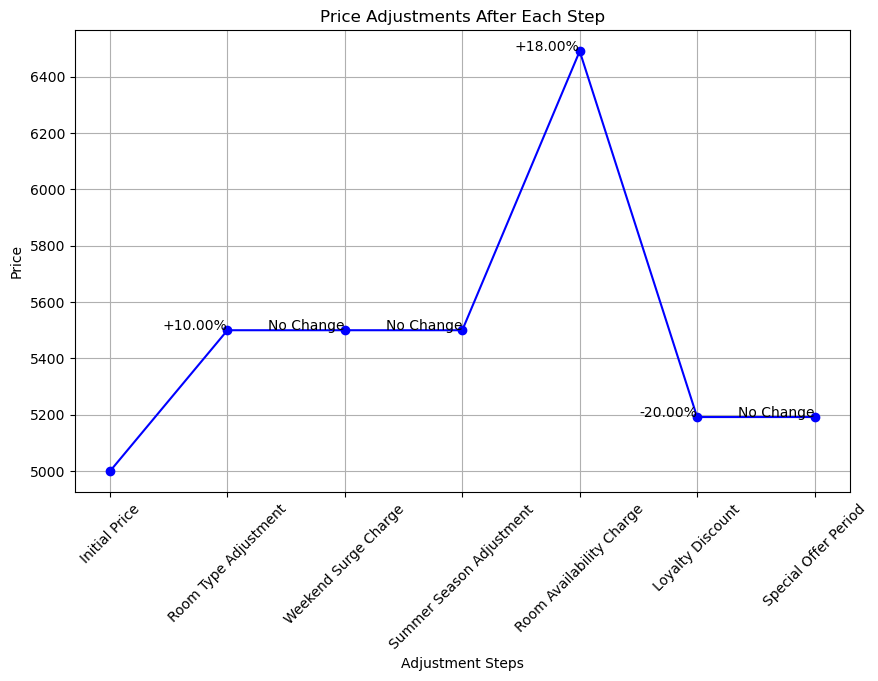

In [15]:
from sqlalchemy import create_engine, Column, Integer, String, Boolean, DateTime, ForeignKey
from sqlalchemy.orm import declarative_base, sessionmaker, relationship
import datetime
from prettytable import PrettyTable
import matplotlib.pyplot as plt
import time
from IPython.display import display, clear_output
from fpdf import FPDF
import pandas as pd
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.application import MIMEApplication
import yagmail 

# Database connection parameters
username = 'root'
password = 'iamukr77'
host = 'localhost'
port = '3306'  # Default MySQL port
database = 'hms'  # Your schema name

# Create an engine instance with provided credentials
engine = create_engine(f'mysql+pymysql://{username}:{password}@{host}:{port}/{database}')

# Define the ORM base class
Base = declarative_base()

# Define the ORM mapping for the rooms table
class Room(Base):
    __tablename__ = 'rooms'
    id = Column(Integer, primary_key=True, autoincrement=True)
    room_no = Column(Integer, unique=True)
    price = Column(Integer)
    room_type = Column(String(2))
    currently_booked = Column(Boolean, default=False)
    created_at = Column(DateTime, default=datetime.datetime.utcnow)

    reservations = relationship("Reservation", back_populates="room")

# Define the ORM mapping for the reservations table
class Reservation(Base):
    __tablename__ = 'reservations'
    id = Column(Integer, primary_key=True, autoincrement=True)
    g_id = Column(Integer, ForeignKey('guests.id'))
    r_date = Column(DateTime)
    check_in = Column(DateTime)
    check_out = Column(DateTime)
    meal = Column(Boolean)
    r_id = Column(Integer, ForeignKey('rooms.id'))
    r_type = Column(String(2))
    created_at = Column(DateTime, default=datetime.datetime.utcnow)

    guest = relationship("Guest", back_populates="reservations")
    room = relationship("Room", back_populates="reservations")

# Define the ORM mapping for the guests table
class Guest(Base):
    __tablename__ = 'guests'
    id = Column(Integer, primary_key=True, autoincrement=True)
    name = Column(String(30))
    address = Column(String(50))
    email_id = Column(String(50))
    phone = Column(Integer)
    city = Column(String(20))
    created_at = Column(DateTime, default=datetime.datetime.utcnow)

    reservations = relationship("Reservation", back_populates="guest")

# Create a sessionmaker
Session = sessionmaker(bind=engine)

# Function to calculate dynamic price based on room type, weekends, and summer season
def calculate_dynamic_price(room, reservation):
    prices = []
    labels = []
    changes = []
    
    base_price = 5000  # Example base price
    prices.append(base_price)
    labels.append('Initial Price')
    changes.append('')
    print(f"Initial Price => {base_price}")
    
    # Adjust price based on room type
    previous_price = base_price
    if room.room_type == 'D':  # Deluxe room
        base_price += 1000
    elif room.room_type == 'N':  # Normal room
        base_price += 500
    
    percentage_change = ((base_price - previous_price) / previous_price) * 100
    prices.append(base_price)
    labels.append('Room Type Adjustment')
    changes.append(f"+{percentage_change:.2f}%" if percentage_change != 0 else "No Change")
    print(f"Price After Room Type Adjustment => {base_price} ({changes[-1]})")
    
    # Check if the check_in date was a weekend
    previous_price = base_price
    created_at_date = reservation.check_in
    is_weekend_flag = created_at_date.weekday() >= 5  # 5 represents Saturday, 6 represents Sunday

    if is_weekend_flag:
        base_price *= 1.05  # Increase price by 5% for rooms created on weekends
    
    percentage_change = ((base_price - previous_price) / previous_price) * 100
    prices.append(int(base_price))
    labels.append('Weekend Surge Charge')
    changes.append(f"+{percentage_change:.2f}%" if percentage_change != 0 else "No Change")
    print(f"Price After Weekend Surge Charge => {int(base_price)} ({changes[-1]})")
    
    # Check if the created_at date falls within the summer season (March and April)
    previous_price = base_price
    if created_at_date.month in [3, 4]:
        base_price *= 1.15  # Increase price by 15% for rooms booked during the summer season
    
    percentage_change = ((base_price - previous_price) / previous_price) * 100
    prices.append(int(base_price))
    labels.append('Summer Season Adjustment')
    changes.append(f"+{percentage_change:.2f}%" if percentage_change != 0 else "No Change")
    print(f"Price After Summer Season Adjustment => {int(base_price)} ({changes[-1]})")
    
    return int(base_price), prices, labels, changes

# Function to check if the room is booked
def is_room_booked(room_no, session):
    reservation = session.query(Reservation).join(Room).filter(Room.room_no == room_no, Reservation.check_out == None).first()
    return reservation is not None

# Function to apply dynamic price based on room availability
def update_room_price(room_no, session, current_price):
    previous_price = current_price
    if is_room_booked(room_no, session):
        current_price *= 1.18  # Increase price by 18%
    
    percentage_change = ((current_price - previous_price) / previous_price) * 100
    print(f"Price After Room Availability Charge => {int(current_price)} ({f'+{percentage_change:.2f}%' if percentage_change != 0 else 'No Change'})")
    return int(current_price), f"+{percentage_change:.2f}%" if percentage_change != 0 else "No Change"

# Function to apply loyalty discount
def apply_loyalty_discount(current_price, guest):
    previous_price = current_price
    if guest.email_id in ['ukr@abc.in', 'utkarsh.roy25@gmail.com']:
        current_price = int(current_price * 0.8)  # Apply 20% discount
    
    percentage_change = ((current_price - previous_price) / previous_price) * 100
    print(f"Price After Loyalty Discount => {current_price} ({f'{percentage_change:.2f}%' if percentage_change != 0 else 'No Change'})")
    return current_price, f"{percentage_change:.2f}%" if percentage_change != 0 else "No Change"

# Function to apply special offer period specific date
def apply_special_offer(current_price, reservation):
    previous_price = current_price
    offer_start_date = datetime.datetime(2024, 4, 20)
    offer_end_date = datetime.datetime(2024, 4, 30)
    
    if offer_start_date <= reservation.check_in <= offer_end_date:
        current_price = int(current_price * 0.93)  # Apply 7% discount
    
    percentage_change = ((current_price - previous_price) / previous_price) * 100
    print(f"Price After Special Offer Period => {current_price} ({f'{percentage_change:.2f}%' if percentage_change != 0 else 'No Change'})")
    return current_price, f"{percentage_change:.2f}%" if percentage_change != 0 else "No Change"


        
# Function to fetch and display guest information along with reservation and room details
def get_guest_info(guest_id, session, final_price):
    guest = session.query(Guest).filter_by(id=guest_id).first()
    reservation = session.query(Reservation).filter_by(g_id=guest_id, check_out=None).first()
    room = session.query(Room).filter_by(id=reservation.r_id).first() if reservation else None
    
    current_time = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    
    if guest and reservation and room:
        # Create a PrettyTable instance
        table = PrettyTable()
        table.field_names = ["Field", "Data"]
        table.max_width["Field"] = 20
        table.max_width["Data"] = 50
        table.add_row(["Name", guest.name])
        table.add_row(["Address", guest.address])
        table.add_row(["Email", guest.email_id])
        table.add_row(["Phone", guest.phone])
        table.add_row(["Check-in Date", reservation.check_in.strftime('%Y-%m-%d %H:%M:%S')])
        table.add_row(["Room Number", room.room_no])
        table.add_row(["Room Type", room.room_type])
        table.add_row(["Room Price", final_price])
        table.add_row(["Booking Time", current_time])
        
        # Save PrettyTable data to PDF
        save_table_to_pdf(guest.id, session, final_price)
        
        print("\nBooking Information:")
        print(table)
    else:
        print(f"No guest or reservation found with ID {guest_id}")

# Function to display animated calculation steps
def display_price_calculation_animation():
    messages = [
       "\033[1mVerifying base price...🔎\033[0m",
       "\033[1mAdjusting price based on room type...🏡\033[0m",
       "\033[1mChecking for weekend surge charge...🚀\033[0m",
       "\033[1mInspecting summer season adjustment...⛱️\033[0m",
       "\033[1mValidating room availability...🚨\033[0m",
       "\033[1mApplying loyalty discount...🎁\033[0m",
       "\033[1mCalculating special offer discount...🌟\033[0m",
        "\033[1mDone!✅\033[0m",
       "\033[1mDisplaying Final Price with the Breakdown..💻\033[0m"
    ]
    for message in messages:
        clear_output(wait=True)
        print(message)
        time.sleep(1)  
    clear_output(wait=True)

# Function to save PrettyTable data to PDF
class PDF(FPDF):
    def header(self):
        self.set_font('Arial', 'B', 12)
        self.cell(0, 10, '       Booking Information', 0, 1, 'C')

    def chapter_title(self, title):
        self.set_font('Arial', 'B', 12)
        self.cell(0, 10, title, 0, 1, 'L')
        self.ln(5)

    def chapter_body(self, body):
        self.set_font('Arial', '', 12)
        self.multi_cell(0, 10, body)
        self.ln()

    def add_table(self, table):
        self.set_font('Arial', 'B', 12)
        col_widths = [self.get_string_width(col) for col in table.field_names]
        col_widths = [max(w, 80) for w in col_widths]  # Minimum column width

        # Header
        for i, field in enumerate(table.field_names):
            self.cell(col_widths[i], 10, field, 1, 0, 'C')
        self.ln()

        # Data
        self.set_font('Arial', '', 12)
        for row in table.rows:
            for i, field in enumerate(row):
                self.cell(col_widths[i], 10, str(field), 1, 0, 'C')
            self.ln()

def save_table_to_pdf(guest_id, session, final_price):
    guest = session.query(Guest).filter_by(id=guest_id).first()
    reservation = session.query(Reservation).filter_by(g_id=guest_id, check_out=None).first()
    room = session.query(Room).filter_by(id=reservation.r_id).first() if reservation else None

    if guest and reservation and room:
        # Create a PrettyTable instance for the data
        table = PrettyTable()
        table.field_names = ["Field", "Data"]

        # Data to be added
        data = [
            ["Name", guest.name],
            ["Address", guest.address],
            ["Email", guest.email_id],
            ["Phone", guest.phone],
            ["Check-in Date", reservation.check_in.strftime('%Y-%m-%d %H:%M:%S')],
            ["Room Number", room.room_no],
            ["Room Type", room.room_type],
            ["Room Price", final_price],
            ["Booking Time", datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')]
        ]

        # Add rows to the table
        for row in data:
            table.add_row(row)

        # Calculate max width based on content length
        table.max_width["Field"] = max(len(row[0]) for row in data) + 5  # +5 for padding
        table.max_width["Data"] = max(len(str(row[1])) for row in data) + 5  # +5 for padding

        # Create the PDF
        pdf = PDF()
        pdf.add_page()

        # Add header and introductory text
        pdf.set_font("Arial", 'B', 16)
        pdf.cell(200, 10, txt="SmartStay", ln=True, align='C')
        pdf.set_font("Arial", 'I', 12)
        pdf.cell(200, 10, txt="Your Booking Receipt", ln=True, align='C')
        pdf.ln(10)

        # Add professional introduction
        pdf.set_font("Arial", '', 12)
        pdf.multi_cell(0, 10, 
            "Dear {name},\n\n"
            "Thank you for choosing our hotel for your stay. We are pleased to confirm your booking and "
            "hope you have a pleasant experience with us. Below are the details of your reservation.\n\n".format(name=guest.name)
        )
        
        # Add table with booking information
        pdf.add_table(table)

        # Add footer
        pdf.ln(10)
        pdf.set_font("Arial", 'I', 10)
        pdf.multi_cell(0, 10,
            "For any inquiries or additional assistance, please contact us at support@smartStay.tcet or call us at (123) 456-7890.\n"
            "We look forward to welcoming you to our hotel.\n\n"
            "Sincerely,\nSmartStay Team"
        )

        # Save the PDF
        pdf_file_name = f"Booking_Info_{guest_id}.pdf"
        pdf.output(pdf_file_name)

        print(f"PDF saved as {pdf_file_name}")
        
        # Send the PDF via email
        try:
            yag = yagmail.SMTP("smartstaytcet@gmail.com", "vmla cyse ruho svsc") 
            subject = "Your Booking Information - SmartStay"
            body = "Dear Guest,\n\nPlease find attached your booking information.\n\nBest Regards,\nSmartStay Team"
            yag.send(to=guest.email_id, subject=subject, contents=body, attachments=pdf_file_name)
            print(f"\033[1mEmail sent successfully to guest registered email id!\033[0m")
        except Exception as e:
            print(f"Failed to send email: {e}")
    else:
        print("No guest or reservation found.")
        

# Main function
def update_room_price_main():
    try:
        # Create a session
        session = Session()
        
        # Take room number input from the user
        room_number_to_update = int(input("Enter the room number to update: "))
        
        # Fetch the room with the specific room_no
        room = session.query(Room).filter_by(room_no=room_number_to_update).first()
    
        if room:
            # Fetch the reservation associated with the room
            reservation = session.query(Reservation).filter_by(r_id=room.id, check_out=None).first()
    
            if reservation:
                # Fetch the guest associated with the reservation
                guest = session.query(Guest).filter_by(id=reservation.g_id).first()
                
                # Display the price calculation animation
                display_price_calculation_animation()

                # Calculate the new dynamic price
                new_price, prices, labels, changes = calculate_dynamic_price(room, reservation)
    
                # Apply dynamic price based on room availability
                new_price, change = update_room_price(room.room_no, session, new_price)
                prices.append(new_price)
                labels.append('Room Availability Charge')
                changes.append(change)
    
                # Apply loyalty discount if applicable
                new_price, change = apply_loyalty_discount(new_price, guest)
                prices.append(new_price)
                labels.append('Loyalty Discount')
                changes.append(change)
                
                # Apply special offer period specific date
                new_price, change = apply_special_offer(new_price, reservation)
                prices.append(new_price)
                labels.append('Special Offer Period')
                changes.append(change)
    
                # Update the price in the database
                room.price = new_price
                session.commit()  # Commit the changes
                
                # Save guest information to PDF
                get_guest_info(guest.id, session, new_price)
                
                # Print the final price update message in bold
                print(f"\033[1mFinal price updated successfully for room {room_number_to_update} to {new_price}✔️\033[0m")
                
                # To verify the update, fetch the data again and display the updated DataFrame
                query = f"SELECT * FROM rooms WHERE room_no = {room_number_to_update}"
                data = pd.read_sql(query, engine)
                display(data)
            
    
                # Plot the price changes
                plt.figure(figsize=(10, 6))
                plt.plot(labels, prices, marker='o', linestyle='-', color='b')
                for i, (label, price, change) in enumerate(zip(labels, prices, changes)):
                    plt.text(i, price, f'{change}', ha='right')
                plt.xlabel('Adjustment Steps')
                plt.ylabel('Price')
                plt.title('Price Adjustments After Each Step')
                plt.xticks(rotation=45)
                plt.grid(True)
                plt.show()
    
            else:
                print(f"No active reservation found for room number {room_number_to_update}.")
    
        else:
            print(f"No room found with number {room_number_to_update}.")
    
    except Exception as e:
        print(f"An error occurred: {e}")

    finally:
        # Close the session
        session.close()

# Execute the main function
update_room_price_main()

In [ ]:
# Updated Receipt 

Initial Price => 5000
Price After Room Type Adjustment => 5500 (+10.00%)
Price After Weekend Surge Charge => 5500 (No Change)
Price After Summer Season Adjustment => 5500 (No Change)
Price After Room Availability Charge => 6490 (+18.00%)
Price After Loyalty Discount => 5192 (-20.00%)
Price After Special Offer Period => 5192 (No Change)
PDF saved as Booking_Info_7.pdf
Email sent successfully to guest registered email id!

Booking Information:
+---------------+-------------------------+
|     Field     |           Data          |
+---------------+-------------------------+
|      Name     |         utkarsh         |
|    Address    |        Kandivali        |
|     Email     | utkarsh.roy25@gmail.com |
|     Phone     |        898776546        |
| Check-in Date |   2024-09-25 11:11:12   |
|  Room Number  |            18           |
|   Room Type   |            N            |
|   Room Price  |           5192          |
|  Booking Time |   2024-08-10 21:31:17   |
+---------------+---------

,id,room_no,price,room_type,currently_booked,created_at
0,18,18,5192,N,0,2024-07-18 22:01:37


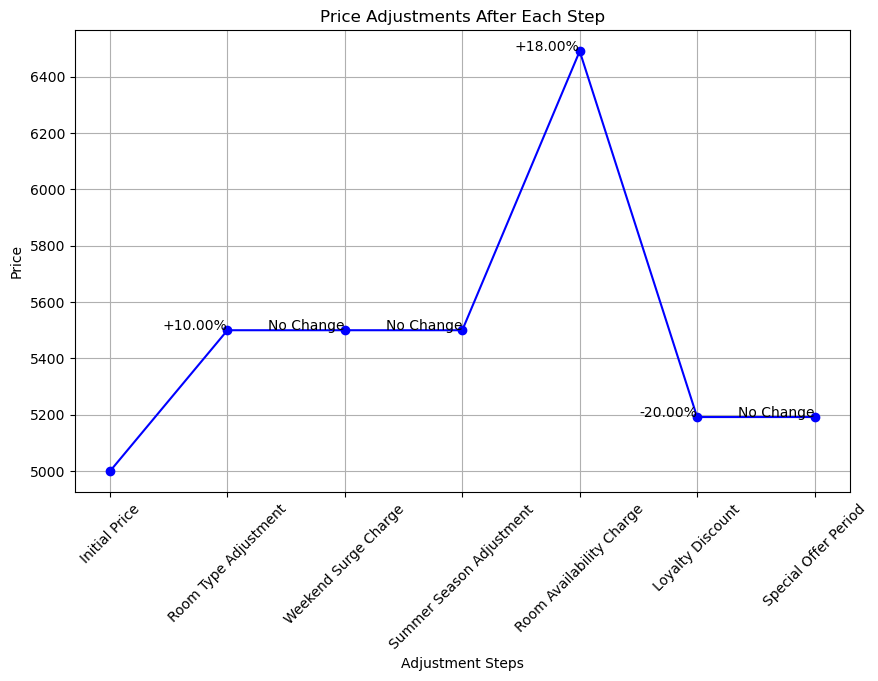

In [23]:
from sqlalchemy import create_engine, Column, Integer, String, Boolean, DateTime, ForeignKey
from sqlalchemy.orm import declarative_base, sessionmaker, relationship
import datetime
from prettytable import PrettyTable
import matplotlib.pyplot as plt
import time
from IPython.display import display, clear_output
from fpdf import FPDF
import pandas as pd
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.application import MIMEApplication
import yagmail 

# Database connection parameters
username = 'root'
password = 'iamukr77'
host = 'localhost'
port = '3306'  # Default MySQL port
database = 'hms'  # Your schema name

# Create an engine instance with provided credentials
engine = create_engine(f'mysql+pymysql://{username}:{password}@{host}:{port}/{database}')

# Define the ORM base class
Base = declarative_base()

# Define the ORM mapping for the rooms table
class Room(Base):
    __tablename__ = 'rooms'
    id = Column(Integer, primary_key=True, autoincrement=True)
    room_no = Column(Integer, unique=True)
    price = Column(Integer)
    room_type = Column(String(2))
    currently_booked = Column(Boolean, default=False)
    created_at = Column(DateTime, default=datetime.datetime.utcnow)

    reservations = relationship("Reservation", back_populates="room")

# Define the ORM mapping for the reservations table
class Reservation(Base):
    __tablename__ = 'reservations'
    id = Column(Integer, primary_key=True, autoincrement=True)
    g_id = Column(Integer, ForeignKey('guests.id'))
    r_date = Column(DateTime)
    check_in = Column(DateTime)
    check_out = Column(DateTime)
    meal = Column(Boolean)
    r_id = Column(Integer, ForeignKey('rooms.id'))
    r_type = Column(String(2))
    created_at = Column(DateTime, default=datetime.datetime.utcnow)

    guest = relationship("Guest", back_populates="reservations")
    room = relationship("Room", back_populates="reservations")

# Define the ORM mapping for the guests table
class Guest(Base):
    __tablename__ = 'guests'
    id = Column(Integer, primary_key=True, autoincrement=True)
    name = Column(String(30))
    address = Column(String(50))
    email_id = Column(String(50))
    phone = Column(Integer)
    city = Column(String(20))
    created_at = Column(DateTime, default=datetime.datetime.utcnow)

    reservations = relationship("Reservation", back_populates="guest")

# Create a sessionmaker
Session = sessionmaker(bind=engine)

# Function to calculate dynamic price based on room type, weekends, and summer season
def calculate_dynamic_price(room, reservation):
    prices = []
    labels = []
    changes = []
    
    base_price = 5000  # Example base price
    prices.append(base_price)
    labels.append('Initial Price')
    changes.append('')
    print(f"Initial Price => {base_price}")
    
    # Adjust price based on room type
    previous_price = base_price
    if room.room_type == 'D':  # Deluxe room
        base_price += 1000
    elif room.room_type == 'N':  # Normal room
        base_price += 500
    
    percentage_change = ((base_price - previous_price) / previous_price) * 100
    prices.append(base_price)
    labels.append('Room Type Adjustment')
    changes.append(f"+{percentage_change:.2f}%" if percentage_change != 0 else "No Change")
    print(f"Price After Room Type Adjustment => {base_price} ({changes[-1]})")
    
    # Check if the check_in date was a weekend
    previous_price = base_price
    created_at_date = reservation.check_in
    is_weekend_flag = created_at_date.weekday() >= 5  # 5 represents Saturday, 6 represents Sunday

    if is_weekend_flag:
        base_price *= 1.05  # Increase price by 5% for rooms created on weekends
    
    percentage_change = ((base_price - previous_price) / previous_price) * 100
    prices.append(int(base_price))
    labels.append('Weekend Surge Charge')
    changes.append(f"+{percentage_change:.2f}%" if percentage_change != 0 else "No Change")
    print(f"Price After Weekend Surge Charge => {int(base_price)} ({changes[-1]})")
    
    # Check if the created_at date falls within the summer season (March and April)
    previous_price = base_price
    if created_at_date.month in [3, 4]:
        base_price *= 1.15  # Increase price by 15% for rooms booked during the summer season
    
    percentage_change = ((base_price - previous_price) / previous_price) * 100
    prices.append(int(base_price))
    labels.append('Summer Season Adjustment')
    changes.append(f"+{percentage_change:.2f}%" if percentage_change != 0 else "No Change")
    print(f"Price After Summer Season Adjustment => {int(base_price)} ({changes[-1]})")
    
    return int(base_price), prices, labels, changes

# Function to check if the room is booked
def is_room_booked(room_no, session):
    reservation = session.query(Reservation).join(Room).filter(Room.room_no == room_no, Reservation.check_out == None).first()
    return reservation is not None

# Function to apply dynamic price based on room availability
def update_room_price(room_no, session, current_price):
    previous_price = current_price
    if is_room_booked(room_no, session):
        current_price *= 1.18  # Increase price by 18%
    
    percentage_change = ((current_price - previous_price) / previous_price) * 100
    print(f"Price After Room Availability Charge => {int(current_price)} ({f'+{percentage_change:.2f}%' if percentage_change != 0 else 'No Change'})")
    return int(current_price), f"+{percentage_change:.2f}%" if percentage_change != 0 else "No Change"

# Function to apply loyalty discount
def apply_loyalty_discount(current_price, guest):
    previous_price = current_price
    if guest.email_id in ['ukr@abc.in', 'utkarsh.roy25@gmail.com']:
        current_price = int(current_price * 0.8)  # Apply 20% discount
    
    percentage_change = ((current_price - previous_price) / previous_price) * 100
    print(f"Price After Loyalty Discount => {current_price} ({f'{percentage_change:.2f}%' if percentage_change != 0 else 'No Change'})")
    return current_price, f"{percentage_change:.2f}%" if percentage_change != 0 else "No Change"

# Function to apply special offer period specific date
def apply_special_offer(current_price, reservation):
    previous_price = current_price
    offer_start_date = datetime.datetime(2024, 4, 20)
    offer_end_date = datetime.datetime(2024, 4, 30)
    
    if offer_start_date <= reservation.check_in <= offer_end_date:
        current_price = int(current_price * 0.93)  # Apply 7% discount
    
    percentage_change = ((current_price - previous_price) / previous_price) * 100
    print(f"Price After Special Offer Period => {current_price} ({f'{percentage_change:.2f}%' if percentage_change != 0 else 'No Change'})")
    return current_price, f"{percentage_change:.2f}%" if percentage_change != 0 else "No Change"


        
# Function to fetch and display guest information along with reservation and room details
def get_guest_info(guest_id, session, final_price, prices, labels, changes):
    guest = session.query(Guest).filter_by(id=guest_id).first()
    reservation = session.query(Reservation).filter_by(g_id=guest_id, check_out=None).first()
    room = session.query(Room).filter_by(id=reservation.r_id).first() if reservation else None
    
    current_time = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    
    if guest and reservation and room:
        # Create a PrettyTable instance
        table = PrettyTable()
        table.field_names = ["Field", "Data"]
        table.max_width["Field"] = 20
        table.max_width["Data"] = 50
        table.add_row(["Name", guest.name])
        table.add_row(["Address", guest.address])
        table.add_row(["Email", guest.email_id])
        table.add_row(["Phone", guest.phone])
        table.add_row(["Check-in Date", reservation.check_in.strftime('%Y-%m-%d %H:%M:%S')])
        table.add_row(["Room Number", room.room_no])
        table.add_row(["Room Type", room.room_type])
        table.add_row(["Room Price", final_price])
        table.add_row(["Booking Time", current_time])
        
        # Save PrettyTable data to PDF
        save_table_to_pdf(guest.id, session, final_price, prices, labels, changes)
        
        print("\nBooking Information:")
        print(table)
    else:
        print(f"No guest or reservation found with ID {guest_id}")



# Function to display animated calculation steps
def display_price_calculation_animation():
    messages = [
       "\033[1mVerifying base price...🔎\033[0m",
       "\033[1mAdjusting price based on room type...🏡\033[0m",
       "\033[1mChecking for weekend surge charge...🚀\033[0m",
       "\033[1mInspecting summer season adjustment...⛱️\033[0m",
       "\033[1mValidating room availability...🚨\033[0m",
       "\033[1mApplying loyalty discount...🎁\033[0m",
       "\033[1mCalculating special offer discount...🌟\033[0m",
        "\033[1mDone!✅\033[0m",
       "\033[1mDisplaying Final Price with the Breakdown..💻\033[0m"
    ]
    for message in messages:
        clear_output(wait=True)
        print(message)
        time.sleep(1)  
    clear_output(wait=True)

# Function to save PrettyTable data to PDF
class PDF(FPDF):
    def header(self):
        self.set_font('Arial', 'B', 12)
        self.cell(0, 10, '        Booking Information', 0, 1, 'C')

    def chapter_title(self, title):
        self.set_font('Arial', 'B', 12)
        self.cell(0, 10, title, 0, 1, 'L')
        self.ln(5)

    def chapter_body(self, body):
        self.set_font('Arial', '', 12)
        self.multi_cell(0, 10, body)
        self.ln()

    def add_table(self, table):
        self.set_font('Arial', 'B', 12)
        col_widths = [self.get_string_width(col) for col in table.field_names]
        col_widths = [max(w, 80) for w in col_widths]  # Minimum column width

        # Header
        for i, field in enumerate(table.field_names):
            self.cell(col_widths[i], 10, field, 1, 0, 'C')
        self.ln()

        # Data
        self.set_font('Arial', '', 12)
        for row in table.rows:
            for i, field in enumerate(row):
                self.cell(col_widths[i], 10, str(field), 1, 0, 'C')
            self.ln()

    def add_narrow_table(self, table):
        self.set_font('Arial', 'B', 12)
        col_widths = [self.get_string_width(col) for col in table.field_names]
        col_widths = [max(w, 55) for w in col_widths]  # Minimum column width

        # Header
        for i, field in enumerate(table.field_names):
            self.cell(col_widths[i], 10, field, 1, 0, 'C')
        self.ln()

        # Data
        self.set_font('Arial', '', 12)
        for row in table.rows:
            for i, field in enumerate(row):
                self.cell(col_widths[i], 10, str(field), 1, 0, 'C')
            self.ln()

    def add_page_title(self, title):
        self.add_page()
        self.set_font('Arial', 'B', 14)
        self.cell(0, 10, title, 0, 1, 'C')
        self.ln(10)

def save_table_to_pdf(guest_id, session, final_price, prices, labels, changes):
    guest = session.query(Guest).filter_by(id=guest_id).first()
    reservation = session.query(Reservation).filter_by(g_id=guest_id, check_out=None).first()
    room = session.query(Room).filter_by(id=reservation.r_id).first() if reservation else None

    if guest and reservation and room:
        # Create a PrettyTable instance for the data
        table = PrettyTable()
        table.field_names = ["Field", "Data"]

        # Data to be added
        data = [
            ["Name", guest.name],
            ["Address", guest.address],
            ["Email", guest.email_id],
            ["Phone", guest.phone],
            ["Check-in Date", reservation.check_in.strftime('%Y-%m-%d %H:%M:%S')],
            ["Room Number", room.room_no],
            ["Room Type", room.room_type],
            ["Room Price", final_price],
            ["Booking Time", datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')]
        ]

        # Add rows to the table
        for row in data:
            table.add_row(row)

        # Calculate max width based on content length
        table.max_width["Field"] = max(len(row[0]) for row in data) + 5  # +5 for padding
        table.max_width["Data"] = max(len(str(row[1])) for row in data) + 5  # +5 for padding

        # Create the PDF
        pdf = PDF()
        pdf.add_page()

        # Add header and introductory text
        pdf.set_font("Arial", 'B', 16)
        pdf.cell(200, 10, txt="SmartStay", ln=True, align='C')
        pdf.set_font("Arial", 'I', 12)
        pdf.cell(200, 10, txt="Your Booking Receipt", ln=True, align='C')
        pdf.ln(10)

        # Add professional introduction
        pdf.set_font("Arial", '', 12)
        pdf.multi_cell(0, 10, 
            "Dear {name},\n\n"
            "Thank you for choosing our hotel for your stay. We are pleased to confirm your booking and "
            "hope you have a pleasant experience with us. Below are the details of your reservation.\n\n".format(name=guest.name)
        )
        
        # Add table with booking information
        pdf.add_table(table)

        # Add Terms & Conditions below the table
        pdf.ln(10)
        pdf.set_font("Arial", 'B', 12)
        pdf.cell(0, 10, 'Terms & Conditions:', 0, 1)
        pdf.set_font("Arial", '', 10)
        pdf.multi_cell(0, 10,
            "1. Prices are subject to change based on SmartStay's Policies.\n"
            "2. All guests are required to provide a valid ID proof at the time of check-in.\n"
            "3. Cancellations made within 24 hours of check-in will incur a 50% charge.\n"
            "4. Pets are not allowed in the hotel premises.\n"
            "5. The hotel is not responsible for the loss of any personal belongings.\n"
        )

        # Add the second page for the dynamic pricing breakdown
        pdf.add_page()
        pdf.chapter_title("Dynamic Pricing Breakdown")
        breakdown_table = PrettyTable()
        breakdown_table.field_names = ["Step", "Price", "Change"]

        for label, price, change in zip(labels, prices, changes):
            breakdown_table.add_row([label, price, change])
        
        pdf.add_narrow_table(breakdown_table)

        # Add footer
        pdf.ln(10)
        pdf.set_font("Arial", 'I', 10)
        pdf.multi_cell(0, 10,
            "For any inquiries or additional assistance, please contact us at smartstaytcet@gmail.com or call us at (123) 456-7890.\n"
            "We look forward to welcoming you to our hotel.\n\n"
            "Sincerely,\nSmartStay Team"
        )

        # Save the PDF
        pdf_file_name = f"Booking_Info_{guest_id}.pdf"
        pdf.output(pdf_file_name)

        print(f"PDF saved as {pdf_file_name}")
        
        # Send the PDF via email
        try:
            yag = yagmail.SMTP("smartstaytcet@gmail.com", "vmla cyse ruho svsc") 
            subject = "Your Booking Information - SmartStay"
            body = "Dear Guest,\n\nPlease find attached your booking information.\n\nBest Regards,\nSmartStay Team"
            yag.send(to=guest.email_id, subject=subject, contents=body, attachments=pdf_file_name)
            print(f"\033[1mEmail sent successfully to guest registered email id!\033[0m")
        except Exception as e:
            print(f"Failed to send email: {e}")
    else:
        print("No guest or reservation found.")

        

# Main function
def update_room_price_main():
    try:
        # Create a session
        session = Session()
        
        # Take room number input from the user
        room_number_to_update = int(input("Enter the room number to update: "))
        
        # Fetch the room with the specific room_no
        room = session.query(Room).filter_by(room_no=room_number_to_update).first()
    
        if room:
            # Fetch the reservation associated with the room
            reservation = session.query(Reservation).filter_by(r_id=room.id, check_out=None).first()
    
            if reservation:
                # Fetch the guest associated with the reservation
                guest = session.query(Guest).filter_by(id=reservation.g_id).first()
                
                # Display the price calculation animation
                display_price_calculation_animation()

                # Calculate the new dynamic price
                new_price, prices, labels, changes = calculate_dynamic_price(room, reservation)
    
                # Apply dynamic price based on room availability
                new_price, change = update_room_price(room.room_no, session, new_price)
                prices.append(new_price)
                labels.append('Room Availability Charge')
                changes.append(change)
    
                # Apply loyalty discount if applicable
                new_price, change = apply_loyalty_discount(new_price, guest)
                prices.append(new_price)
                labels.append('Loyalty Discount')
                changes.append(change)
                
                # Apply special offer period specific date
                new_price, change = apply_special_offer(new_price, reservation)
                prices.append(new_price)
                labels.append('Special Offer Period')
                changes.append(change)
    
                # Update the price in the database
                room.price = new_price
                session.commit()  # Commit the changes
                
                # Save guest information to PDF
                get_guest_info(guest.id, session, new_price, prices, labels, changes)
                
                # Print the final price update message in bold
                print(f"\033[1mFinal price updated successfully for room {room_number_to_update} to {new_price}✔️\033[0m")
                
                # To verify the update, fetch the data again and display the updated DataFrame
                query = f"SELECT * FROM rooms WHERE room_no = {room_number_to_update}"
                data = pd.read_sql(query, engine)
                display(data)
            
    
                # Plot the price changes
                plt.figure(figsize=(10, 6))
                plt.plot(labels, prices, marker='o', linestyle='-', color='b')
                for i, (label, price, change) in enumerate(zip(labels, prices, changes)):
                    plt.text(i, price, f'{change}', ha='right')
                plt.xlabel('Adjustment Steps')
                plt.ylabel('Price')
                plt.title('Price Adjustments After Each Step')
                plt.xticks(rotation=45)
                plt.grid(True)
                plt.show()
    
            else:
                print(f"No active reservation found for room number {room_number_to_update}.")
    
        else:
            print(f"No room found with number {room_number_to_update}.")
    
    except Exception as e:
        print(f"An error occurred: {e}")

    finally:
        # Close the session
        session.close()

# Execute the main function
update_room_price_main()